In [1]:
#import modules
import numpy as np
from numpy import exp, pi
from numpy import linalg as LA
from numpy.fft import fft2, ifft2, fftshift
from matplotlib import pyplot as plt
from matplotlib.pyplot import rc
rc('text', usetex=True)
import cv2
#import files
import sys
sys.path.append('..')
from utils import matrix as mt
from utils import vamp
from utils import HIO

### Abstract  
Phase Retrieval (PR) is the problem of recovering a vector $\boldsymbol{x} \in \mathbb{C}^N$ from the component-wise magnitude of $\bm{z} = A\bm{x}$   $(\bm{z} \in \mathbb{C}^M\ , A \in \mathbb{C}^{M \times N})$. Since the information about the phase of the complex numbers $z_1,...,z_M$ are lost in the observation process, this can be an ill-posed inverse problem. To improve the ill-posed nature of PR, there are mainly two techniques :   

One strategy is to increase the size of dataset by multiple measurements. *Ptychography* in Coherent Diffraction Imaging (CDI), where one image is reconstructed from more than hundreds of diffraction patterns, is an example of such measurement designs.  

Another direction is to exploit the prior knowledge about the unknown image $\boldsymbol{x}$. Bayesian inference is a framework in which such prior knowledge is incorporated within a statistical model, and have been successfully applied to PR in recent years.  

This notebook introduces **Stochastic VAMP** for phase retrieval which integrates the two methods stated above - multiple measurements and Bayesian approach.   

### Setup   
Assume that $\boldsymbol{x} \in \mathbb{C}^N$ is drawn from prior distribution $p_{\text{in}}(\boldsymbol{x})$. Our aim is to estimate unknown vector $\boldsymbol{x}$ from multiple observation vectors $\boldsymbol{y}^{(1)},...,\boldsymbol{y}^{(L)} \in \mathbb{R}^{\bar{M}}$, each of which is modeled as  

$
\boldsymbol{y}^{(l)} \sim p_{\text{out}}(\boldsymbol{y}^{(l)} | |\boldsymbol{z}^{(l)}|) , \ \boldsymbol{z}^{(l)} = A^{(l)} \boldsymbol{x} \ \ (l = 1,...,L)
$

where $A^{(1)},...,A^{(L)} \in \mathbb{C}^{\bar{M} \times N}$ are sensing matrices. For simplicity, we consider Gaussian prior and Rician likelihood as in "VAMP_PR.ipynb". $(A^{(l)})^H A^{(l)}$ is assumed to be diagonal for $l = 1,...,L$.

In [2]:
def PR_multiple_measurement(A_list, gamma_w):
    #inputs : A_list = list of (M, N) matrices, gamma_w = noise precision
    #outputs : x = complex N-vector, y_list = list of real M-vectors
    L, M, N = len(A_list), len(A_list[0]), len(A_list[0][0])
    y_list = []
    x = mt.complex_gaussian_vector(N, 1)
    for l in range(L):
        y = np.abs(A_list[l]@x + mt.complex_gaussian_vector(M, 1/gamma_w))
        y_list.append(y)
    return x, y_list

### Example 1. Haar distributed sensing matrices  
We consider the case where $A^{(1)},...,A^{(L)}$ are i.i.d. drawn from the Haar distribution so that $(A^{(l)})^H A^{(l)} = I_N$. Defining  

$
A = 
\begin{bmatrix}
A^{(1)} \\
\vdots \\
A^{(L)}
\end{bmatrix}\ , \   
$
$
\boldsymbol{z} = 
\begin{bmatrix}
\boldsymbol{z}^{(1)} \\
\vdots \\
\boldsymbol{z}^{(L)}
\end{bmatrix}\ \text{and} \
$
$
\boldsymbol{y} = 
\begin{bmatrix}
\boldsymbol{y}^{(1)} \\
\vdots \\
\boldsymbol{y}^{(L)}
\end{bmatrix}\
$,

the multiple-measurement model is reduced to 
$
\boldsymbol{y} \sim p_{\text{out}}(\boldsymbol{y} | |\boldsymbol{z}|) , \ \boldsymbol{z} = A \boldsymbol{x}
$.
Thus, we can apply VAMP for phase retrieval which is introduced in "PR_VAMP.ipynb" to this problem.  

Another approach is the "Stochastic VAMP" we proposed in our recent work. In short, our method is the VAMP-like expectation propagation on a graphical model with many branches, each of which corresponds to one of the multiple measurements. This approach is motivated by conventional ptychographic reconstruction algorithms such as ePIE, in which likelihood functions w.r.t. each of multiple datasets are sequentially exploited.  

In the following, we compare the VAMP and Stochastic VAMP in the case where the sensing matrices are drawn from Haar distribution.

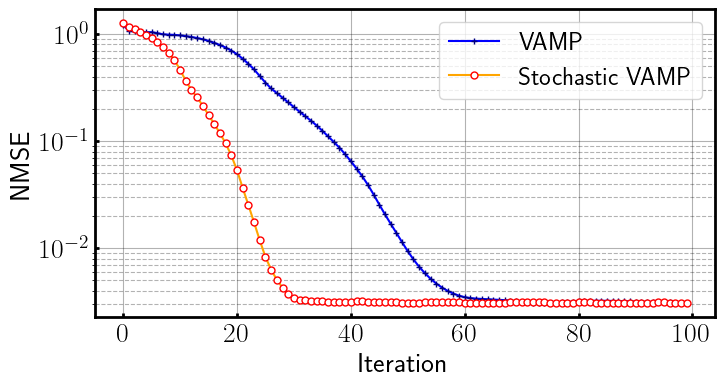

In [3]:
np.random.seed(1)
# data setting
N = 1024 # dimension of x
L = 2 # number of measurements
alpha = 2.4 # sampling ratio (= M*L/N)
M = int(N*alpha/L) # alpha = ML/N. (M > N)
gamma_w = (alpha/L) * 1e3 #SNR = 30dB

#sensing matrices generation
A_list = []
for l in range(L):
    A_list.append(mt.unitary(M)[:, :N]) #Haar distributed matrix

#data generation
x, y_list = PR_multiple_measurement(A_list, gamma_w)

#run VAMP with concatenated data
y, A = np.concatenate(y_list, 0), np.concatenate(A_list, 0)
damping1 = 0.9
Kit = 100
error1 = vamp.PR_VAMP(x, y, A, gamma_w,  damping1, Kit)

#run stochastic vamp
damping2 = 0.97 # Stochastic VAMP (proposed) is stable with less amount of damping (often no dumping is necessary)
error2 = vamp.PR_orthogonal_stochastic_VAMP(x, y_list, A_list, gamma_w, damping2, Kit)
#show result
fig, ax = plt.subplots(1,1, figsize=(8, 4))
plt.tick_params(direction="in", length=3, width=2, labelsize=20)
ax.spines["right"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)
ax.plot(error1, color = "blue", marker = "+", markeredgecolor = "navy", markerfacecolor = "white", markersize = 5, label = "VAMP")
ax.plot(error2, color = "orange", marker = "o", markeredgecolor = "red", markerfacecolor = "white", markersize = 5, label = "Stochastic VAMP")
ax.set_xlabel("Iteration", fontsize = 20)
ax.set_ylabel("NMSE", fontsize = 20)
ax.set_yscale('log')
ax.legend(fontsize = 18)
ax.grid(which='major',color='black',linestyle='-', alpha = 0.3)
ax.grid(which='minor',color='black',linestyle='--', alpha = 0.3)

### Example 2. Coded Diffraction Pattern

Coded Diffraction Pattern (CDP) measurement is a typical example of multiple intensity-measurements. The sensing matrices $A^{(1)},...,A^{(L)} \in \mathbb{C}^{N \times N} $ of CDP are defined as  

$
A^{(l)} = F\  \text{Diag}({\boldsymbol{m}^{(l)}})
$

where $F \in \mathbb{C}^{N \times N}$ is the 2-dimensional Discrete Fourier Transform, and $\boldsymbol{m}^{(l)} \in \mathbb{C}^N$ is a vector of random phase factor, i.e. $m^{(l)}_i  = \exp (\sqrt{-1} \theta^{(l)}_i)\ ,\  \theta^{(l)}_i \sim \text{Unif}(0, 2\pi]\ (l = 1,...,L,\  i = 1,...,N)$. We refer to $\boldsymbol{m}^{(1)},...,\boldsymbol{m}^{(L)}$ as "random phase masks".  

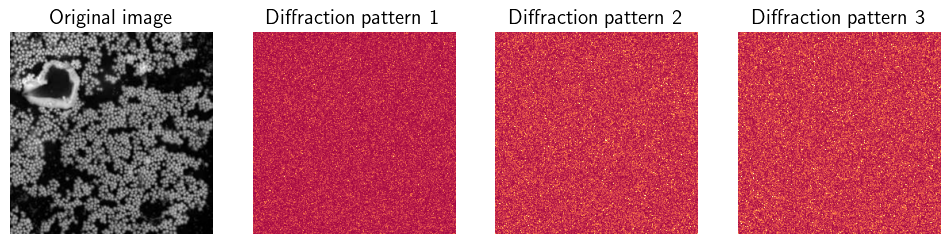

In [4]:
#forward model of CDP
def generate_CDP_data(x, L, gamma_w):
    #inputs : x is 2-d image, L is the number of random phase masks, gamma_w is the noise precision
    n = len(x) # x is n*n pixel image
    mask_list, y_list = [], []
    for l in range(L):
        mask = exp(1j*2*pi * np.random.rand(n,n))
        y = np.abs(fft2(mask*x)/n + mt.complex_gaussian_matrix(n, n , 1/gamma_w))
        mask_list.append(mask)
        y_list.append(y)
    return mask_list, y_list # list of random masks and intensity observations

#generate data x
image = cv2.imread('../data/particle.png', 0) #load image
x = image.astype(float)
x /= LA.norm(x)/len(x) # normalized so that E[x^2] = 1
L = 3 # number of random masks
gamma_w = 1e3 # SNR = 30 dB
mask_list, y_list = generate_CDP_data(x, L, gamma_w)

#show image
fig, ax = plt.subplots(1,L+1, figsize=(3*(L+1), 3))
ax[0].axis("off")
ax[0].set_title("Original image", fontsize = 15)
ax[0].imshow(x, cmap = "gray")
for l in range(1, L+1):
    ax[l].axis("off")
    ax[l].set_title("Diffraction pattern "+str(l), fontsize = 15)
    ax[l].imshow(np.abs(fftshift(np.log10(y_list[l-1]))),cmap = "Spectral")

In the following experiment, we compare Stochastic VAMP and Hybrid-Input-Output (HIO) algorithm by Fienup, using the dataset generated in the previous cell. The conditions are 
- Number of random phase masks : $L = 3$
- Object image : real valued image ($256 \times 256$ pixels, pixel values are within $[0,1]$)
- Noise precision : $\gamma_w = 10^3$  

As it turns out, $L = 3$ is a sufficient number of measurements for Stochastic VAMP to converge, even without using the real-value constraint. On the other hand, the convergence of HIO algorithm with positive real-part constraint takes much more number of iterations, and HIO fails with high probability when the positive real-part constraint is not exploited.

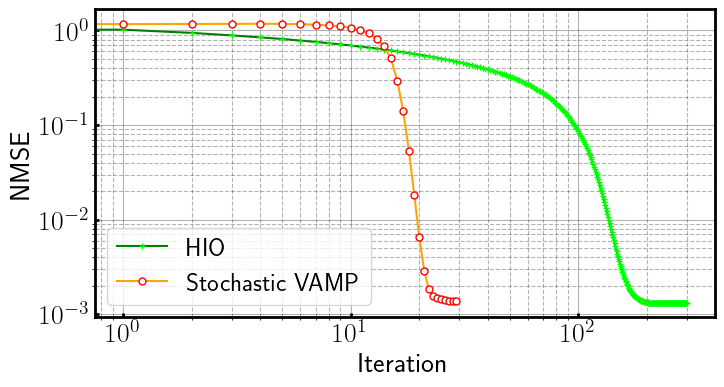

In [5]:
#run VAMP
Kit_VAMP = 30 # maximum iteration number for VAMP
damping = 0.95
error_VAMP, x_VAMP = vamp.CDP_Stochastic_VAMP(x, mask_list, y_list, gamma_w, damping, Kit_VAMP)

#run HIO
beta = 0.9 # tunable parameter in HIO
Kit_HIO = 300 #maximum iteration number for HIO
error_HIO, x_HIO = HIO.HIO_CDP(x, mask_list, y_list, beta, Kit_HIO)

#show results
fig, ax = plt.subplots(1,1, figsize=(8, 4))
plt.tick_params(direction="in", length=3, width=2, labelsize=20)
ax.spines["right"].set_linewidth(2)
ax.spines["left"].set_linewidth(2)
ax.spines["top"].set_linewidth(2)
ax.spines["bottom"].set_linewidth(2)
ax.plot(error_HIO, color = "green", marker = "+", markeredgecolor = "lime", markerfacecolor = "white", markersize = 5, label = "HIO")
ax.plot(error_VAMP, color = "orange", marker = "o", markeredgecolor = "red", markerfacecolor = "white", markersize = 5, label = "Stochastic VAMP")
ax.set_xlabel("Iteration", fontsize = 20)
ax.set_ylabel("NMSE", fontsize = 20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize = 18)
ax.grid(which='major',color='black',linestyle='-', alpha = 0.3)
ax.grid(which='minor',color='black',linestyle='--', alpha = 0.3)

Although the number of Fast Fourier Transforms in each Stochastic VAMP iteration is the same as that of HIO, per-iteration complexity of VAMP can be costly depending on the choice of denoiser. 
In that case, initializing Stochastic VAMP with HIO would be a reasonable strategy. (Theoretical analysis on the convergence of VAMP assumes that the initial input to the iteration has positive correlation with the true signal. In this sense, initializing VAMP with HIO is the right thing to do.)

### References
- **Coded Diffraction Pattern**  
Emmanuel J. Candès, Xiaodong Li and Mahdi Soltanolkotabi, "Phase retrieval from coded diffraction patterns", Applied and Computational Harmonic Analysis, Vol. 39, pp. 277-299 (2015)  

- **Hybrid Input Output algorithm**  
J. R. Fienup, "Phase retrieval algorithms: a comparison," Applied Optics, Vol. 21, pp. 2758-2769 (1982)

- **Stochastic VAMP**  
Hajime Ueda, Shun Katakami, and Masato Okada, "Stochastic Vector Approximate Message Passing with applications to phase retrieval" (pre-print in arXiv)
